(60000, 28, 28)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      5       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      4       0       0       0       0       0       0       0       0   
3      1       0       0       0       0       0       0       0       0   
4      9       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0   

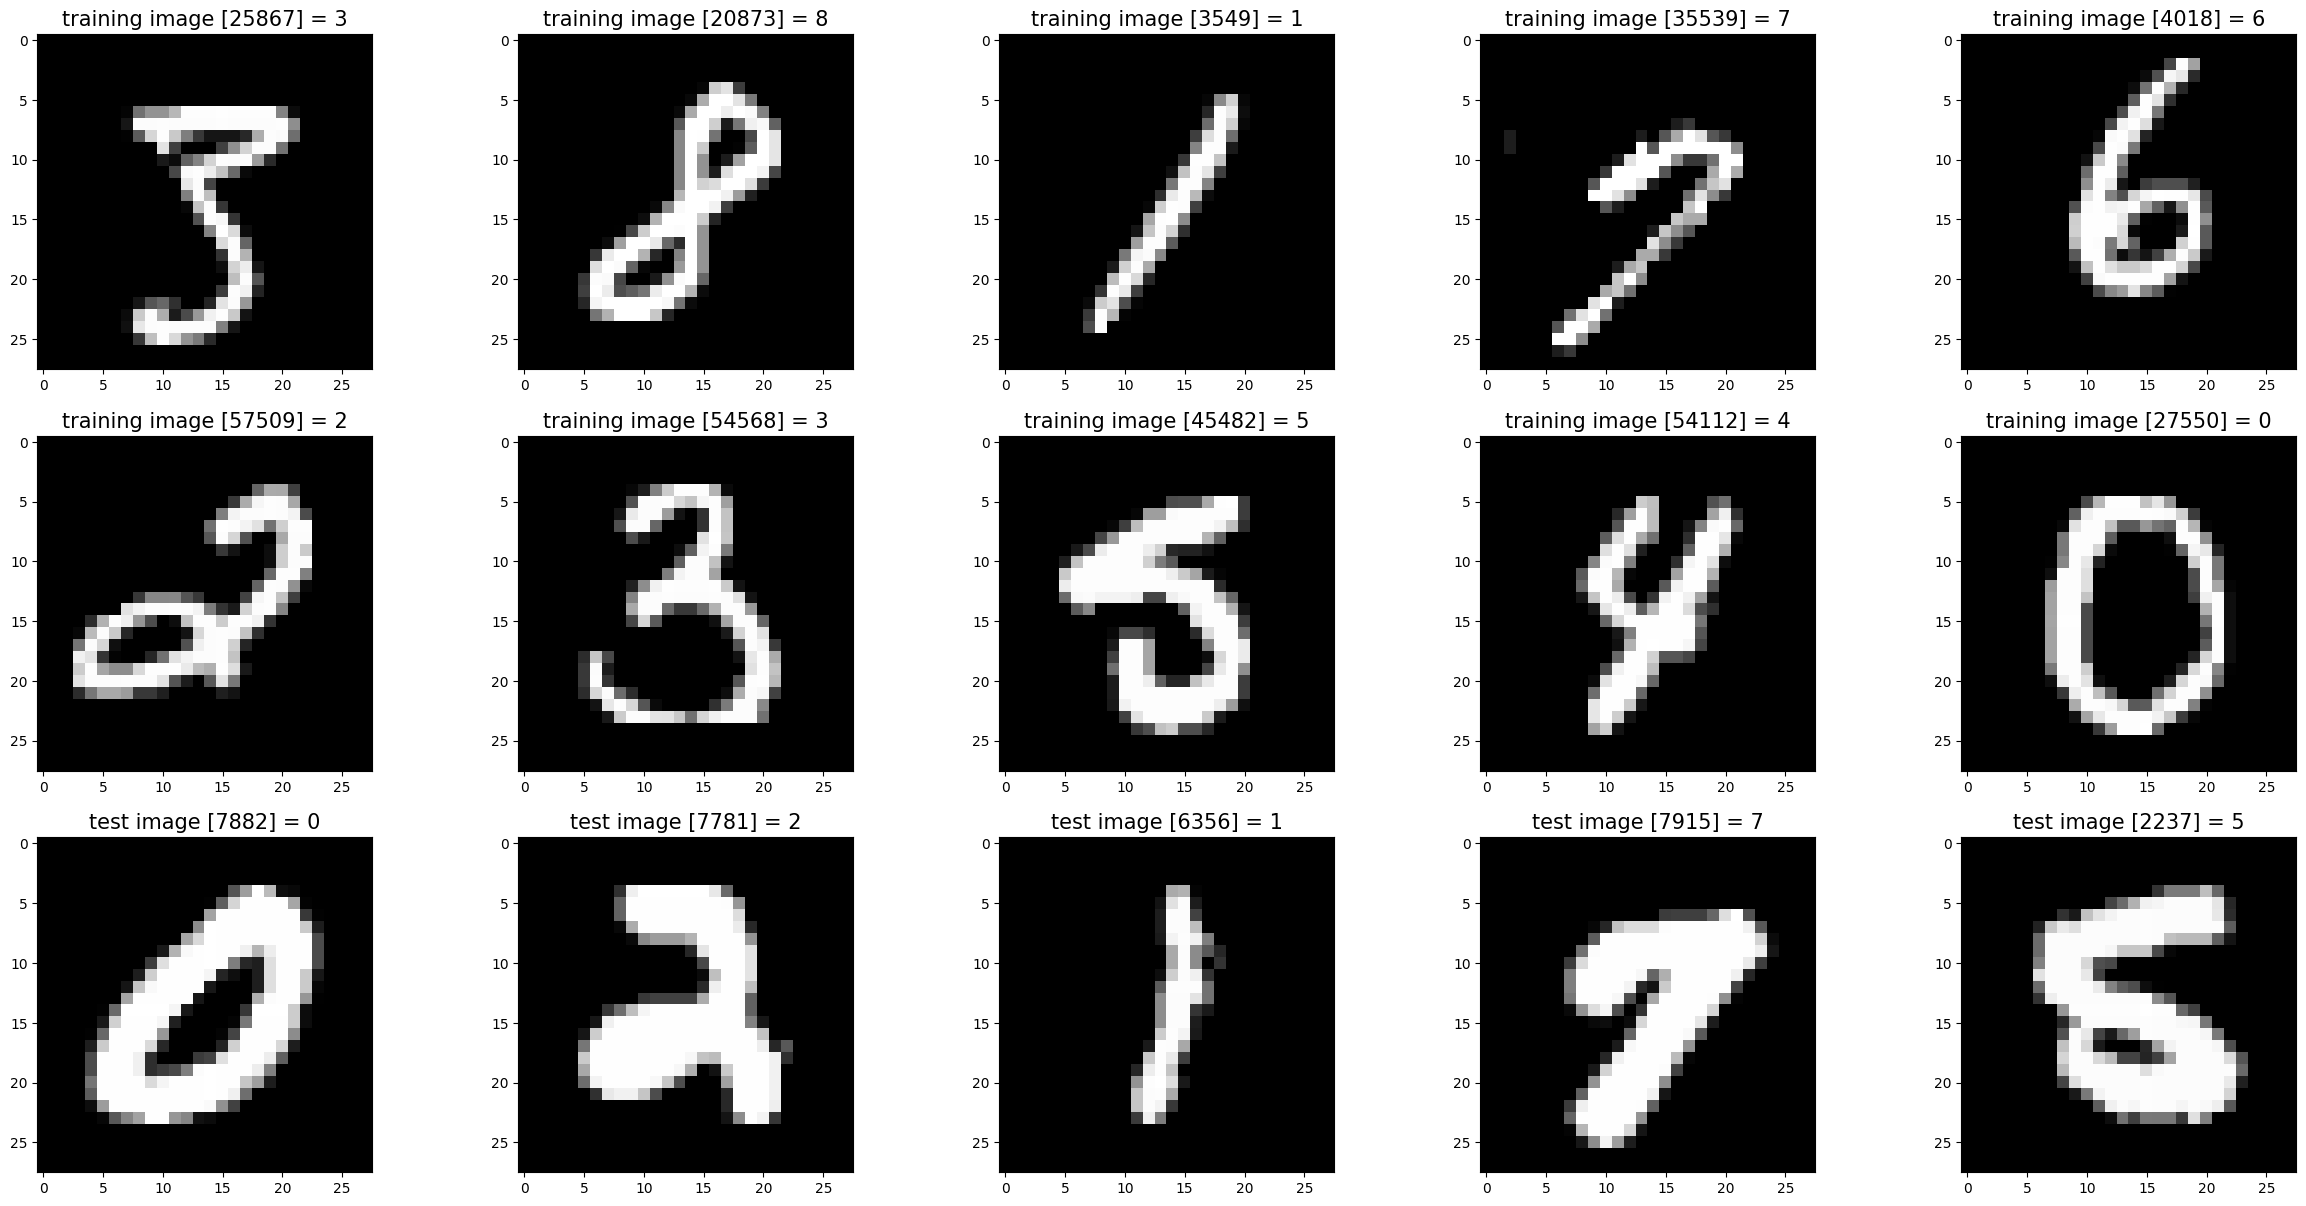

In [1]:
import numpy as np                                                      # linear algebra
import struct
from array import array
from os.path  import join

import pandas as pd                                                 
import matplotlib.pyplot as plt                                         # plotting
import random

# MNIST Data Loader Class
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)



# Verify Reading Dataset via MnistDataloader class
input_path = '../MNIST'
training_images_filepath = join(input_path,'train-images.idx3-ubyte')
training_labels_filepath = join(input_path,'train-labels.idx1-ubyte')
test_images_filepath = join(input_path,'t10k-images.idx3-ubyte')
test_labels_filepath = join(input_path,'t10k-labels.idx1-ubyte')

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MNIST dataset
mnist_data_loader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_data_loader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

print(np.shape(x_train))

training_samples = np.shape(x_train)[0]
x_pixel = np.shape(x_train)[1]
y_pixel = np.shape(x_train)[2]

# Prepare data 
data = []
for i in range(0,training_samples):
    ith_sample_x_train = np.array(x_train[i]).flatten().tolist()
    ith_sample_y_train = np.array(y_train[i]).flatten().tolist()
    data.append(ith_sample_y_train + ith_sample_x_train)

# Prepare DataFrame df
df = pd.DataFrame(data)
columns = ['label']
for i in range(0, 28**2):
    columns.append('pixel{}'.format(i))

df.columns=columns

print(df.head())

# Formatting
data = np.array(df)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets


# Dev data
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.0

# Train data
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.0
_,m_train = X_train.shape

print(Y_train)

# Definition of procs
def init_params():
    W1 = np.random.rand(10,784) - 0.5
    b1 = np.random.rand(10,1) - 0.5
    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(0,Z)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, int(Y.max()) + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def ReLU_deriv(Z):
    return Z > 0

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2,0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

# Run gradient_descent with alpha step
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 25 == 0:
            print("Iteration: ",i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_predictions(index, W1, b1, W2, b2, show_image=False):
    current_image = X_train[:, index, None]
    label = Y_train(index)
    predictions = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    print("Predictions :", predictions)
    print("Label :", label)

    if show_image == True:
        current_image = current_image.reshape((28,28)) * 255
        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.show()


W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.1, 500)

np.save("/home/sagar/Blender_work/mnist_nn_train/dump_data/W1.npy",W1)
np.save("/home/sagar/Blender_work/mnist_nn_train/dump_data/W2.npy",W2)
np.save("/home/sagar/Blender_work/mnist_nn_train/dump_data/b1.npy",b1)
np.save("/home/sagar/Blender_work/mnist_nn_train/dump_data/b2.npy",b2)

X_imgs = X_train[:,0:50]
Z1_50, A1_50, Z2_50, A2_50 = forward_prop(W1, b1, W2, b2, X_imgs[:,0:50])

imgs_count = np.shape(X_imgs)[-1]
W1_mult_X = np.ones(shape=(imgs_count,np.shape(W1)[0],np.shape(W1)[1]))
W2_mult_A1 = np.ones(shape=(imgs_count,np.shape(W2)[0],np.shape(W2)[1]))
for idx in range(0,50):
    A1_50[:,idx] = A1_50[:,idx]/(A1_50[:,idx].max())
    Z1_n, A1_n, Z2_n, A2_n = forward_prop(W1, b1, W2, b2, X_imgs[:,idx,None])
    for j in range(0,10):
        X_img_T = X_imgs[:,idx,None].T
        A1_n_T = A1_n.T
        W1_mult_X[idx][j] = W1[j]*(X_img_T)
        W2_mult_A1[idx][j] = W2[j]*(A1_n_T)

W1_mult_X = np.maximum(W1_mult_X, 0)
W1_mult_X = np.minimum(W1_mult_X, 1)
W2_mult_A1 = np.maximum(W2_mult_A1, 0)
W2_mult_A1 = np.minimum(W2_mult_A1, 1)

np.save("/home/sagar/Blender_work/mnist_nn_train/dump_data/inputs.npy", X_imgs)
np.save("/home/sagar/Blender_work/mnist_nn_train/dump_data/outputs.npy", A2_50)
np.save("/home/sagar/Blender_work/mnist_nn_train/dump_data/weights1.npy", W1_mult_X)
np.save("/home/sagar/Blender_work/mnist_nn_train/dump_data/weights2.npy", W2_mult_A1)
np.save("/home/sagar/Blender_work/mnist_nn_train/dump_data/activations1.npy", A1_50)